In [228]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas_ods_reader import read_ods
from dateutil.parser import parse 

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

import scipy.stats
import pylab

import pyflux as pf

In [229]:
april = pd.read_csv('SiroveKopijeWebexMeetings/April2021_Webex Meetings_Attendees_matf.webex.com_2021-04-01_2021-04-30.csv', parse_dates=['JOIN_DATE'])
may = pd.read_csv('SiroveKopijeWebexMeetings/Maj2021_Webex Meetings_Attendees_matf.webex.com_2021-05-01_2021-05-31.csv', parse_dates=['JOIN_DATE'])

In [230]:
march = read_ods('SiroveKopijeWebexMeetings/Mart2021WebexMeetingsAttendees.ods', 1)
november = read_ods('SiroveKopijeWebexMeetings/NovembarWebex Meetings_Attendees_matf.webex.com_2020-11-01_2020-11-30.ods', 1)

In [231]:
april.head()

,MEETING_NUMBER,MEETING_NAME,CONFERENCE_ID,USER_NAME,EMAIL,LOCATION,JOIN_DATE,START_TIME,END_TIME,DURATION,...,GATEWAY_IP,JOIN_MEETING_TIME,VOIP_PACKET_LOSS,VOIP_LATENCY,TCP_PERCENTAGE,UDP_PERCENTAGE,IS_CMR,IS_SHARING,IS_RECORD,VIDEO_MINUTES
0,1834853439,МАТФ - Увод у веб и интернет технологије (вежб...,189215711830219865,Lena Polic,mi17219@alas.matf.bg.ac.rs,Serbia,2021-04-02,2021-04-02T10:13:34,2021-04-02T11:59:55,107,...,87.116.165.39,0.413,0.00065,50.000000,0.0,1.0,N,N,N,NaN
1,1830843747,"Analiza 3, I smer, 2. tok - vezbe",189755459960315839,Luka Radanovic,mi19169@alas.matf.bg.ac.rs,Serbia,2021-04-01,2021-04-01T09:06:19,2021-04-01T11:02:40,117,...,89.110.244.200,0.849,0.00000,50.000000,0.0,1.0,N,N,N,NaN
2,1833007854,EFM predavanja,189774169196469618,Ilija-Petar Milić,ipmilic@gmail.com,Serbia,2021-04-01,2021-04-01T13:05:16,2021-04-01T13:18:56,14,...,87.116.165.160,0.920,0.00000,50.000000,0.0,1.0,N,N,N,NaN
3,1837521894,Практикум из Анализе 1 - П12,189846157149609508,Jana Mihajlović,janamihajlovic04@gmail.com,Serbia,2021-04-02,2021-04-02T10:15:33,2021-04-02T10:58:13,43,...,109.92.158.89,2.188,0.00000,100.064482,0.0,1.0,N,N,N,NaN
4,1831753884,"г4, вежбе",190106877640580240,Dragana Maljković,mv17007@alas.matf.bg.ac.rs,Serbia,2021-04-05,2021-04-05T07:24:58,2021-04-05T09:07:37,103,...,178.221.45.78,40.543,0.00000,101.919657,0.0,1.0,N,N,N,NaN


In [232]:
april.shape

(22549, 23)

In [233]:
april.columns

Index(['MEETING_NUMBER', 'MEETING_NAME', 'CONFERENCE_ID', 'USER_NAME', 'EMAIL',
       'LOCATION', 'JOIN_DATE', 'START_TIME', 'END_TIME', 'DURATION', 'OS',
       'BROWSER', 'CLIENT_IP', 'GATEWAY_IP', 'JOIN_MEETING_TIME',
       'VOIP_PACKET_LOSS', 'VOIP_LATENCY', 'TCP_PERCENTAGE', 'UDP_PERCENTAGE',
       'IS_CMR', 'IS_SHARING', 'IS_RECORD', 'VIDEO_MINUTES'],
      dtype='object')

In [234]:
#april.isna().sum()

In [235]:
#april.describe()
#april.info()

In [236]:
meetings_per_day_april = april.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
meetings_per_day_march = march.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
meetings_per_day_november = november.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
meetings_per_day_may = may.groupby(['JOIN_DATE']).MEETING_NUMBER.count()

In [237]:
# mart ima dodatni red, izbacujem
meetings_per_day_march = meetings_per_day_march[:-1]

# ne postoji prvi maj, dodajem i dodeljujem 0 kao broj sastanaka tog dana
line = pd.to_datetime("2021-05-01 00:00:00", format="%Y-%m-%d %H:%M:%S")
meetings_per_day_may[line] = 0
meetings_per_day_may = meetings_per_day_may.sort_index()

In [238]:
meetings_per_day_may

JOIN_DATE
2021-05-01      0
2021-05-02      2
2021-05-03     54
2021-05-04     73
2021-05-05    870
2021-05-06    731
2021-05-07    741
2021-05-08     93
2021-05-09     32
2021-05-10    910
2021-05-11    770
2021-05-12    763
2021-05-13    771
2021-05-14    673
2021-05-15     83
2021-05-16     26
2021-05-17    780
2021-05-18    641
2021-05-19    649
2021-05-20    930
2021-05-21    615
2021-05-22    397
2021-05-23     48
2021-05-24    534
2021-05-25    547
2021-05-26    322
2021-05-27    243
2021-05-28    197
2021-05-29     70
2021-05-30     22
2021-05-31    200
Name: MEETING_NUMBER, dtype: int64

In [239]:
def plot_df(df, x, y, title="", xlabel='Datum', ylabel='Vrednost', dpi=100):
    fig = plt.figure(figsize=(16,5), dpi=dpi)
    ax = fig.add_subplot(111)
    ax.plot(x, y, 'tab:purple')
    fig.autofmt_xdate()
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.show()

In [240]:
#plot_df(meetings_per_day_november, meetings_per_day_november.index, meetings_per_day_november.values, title="Broj sastanaka po danu (NOVEMBAR 2020)")
#plot_df(meetings_per_day_march, meetings_per_day_march.index, meetings_per_day_march.values, title="Broj sastanaka po danu (MART 2021)")
#plot_df(meetings_per_day_april, meetings_per_day_april.index, meetings_per_day_april.values, title="Broj sastanaka po danu (APRIL 2021)")
#plot_df(meetings_per_day_may, meetings_per_day_may.index, meetings_per_day_may.values, title="Broj sastanaka po danu (MAJ 2021)")

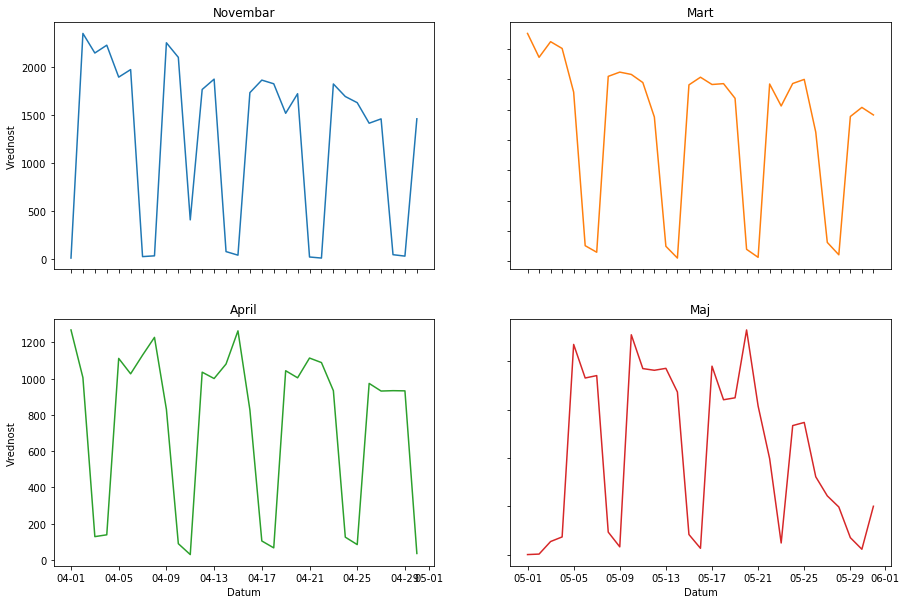

In [241]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
date_form = DateFormatter("%m-%d")


axs[0, 0].plot(meetings_per_day_november.index, meetings_per_day_november.values)
axs[0, 0].set_title('Novembar')
axs[0, 1].plot(meetings_per_day_march.index, meetings_per_day_march.values, 'tab:orange')
axs[0, 1].set_title('Mart')
axs[1, 0].plot(meetings_per_day_april.index, meetings_per_day_april.values, 'tab:green')
axs[1, 0].set_title('April')
axs[1, 0].xaxis.set_major_formatter(date_form)
axs[1, 1].plot(meetings_per_day_may.index, meetings_per_day_may.values, 'tab:red')
axs[1, 1].set_title('Maj')
axs[1, 1].xaxis.set_major_formatter(date_form)


for ax in axs.flat:
    ax.set(xlabel='Datum', ylabel='Vrednost')

for ax in axs.flat:
    ax.label_outer()

Prosecna duzina trajanja sastanaka svaki dan 

In [242]:
#duration_april = april.groupby(['JOIN_DATE']).DURATION.mean()
#plot_df(duration_april, duration_april.index, duration_april.values, title='trajanje april')

In [243]:
#df['Year'] = april.index.year
#df['Month'] = april.index.month
#df['Weekday Name'] = april.index.day_name()

#april.sample(5, random_state=2)

### Stationarity

Vremenska serija je stacionarna ako:
- ima konstantnu srednju vrednost
- ima konstantnu varijansu
- nema sezonsku komponentu

In [244]:
def check_mean(df, name):
    days = df.shape[0]
    one = days//3
    two = 2*days//3

    print(name + ': ')
    print('Prva trecina: {}'.format(df[:one].mean()))
    print('Druga trecina: {}'.format(df[one:two].mean()))
    print('Treca trecina: {}'.format(df[two:].mean()))
    print('Srednja vrednost na celom skupu: {}\n'.format(df.mean()))

In [245]:
check_mean(meetings_per_day_november, 'NOVEMBAR')
check_mean(meetings_per_day_march, 'MART')
check_mean(meetings_per_day_april, 'APRIL')
check_mean(meetings_per_day_may, 'MAJ')

NOVEMBAR: 
Prva trecina: 1498.3
Druga trecina: 1280.8
Treca trecina: 958.2
Srednja vrednost na celom skupu: 1245.7666666666667

MART: 
Prva trecina: 1334.2
Druga trecina: 1014.4
Treca trecina: 970.5454545454545
Srednja vrednost na celom skupu: 1102.0

APRIL: 
Prva trecina: 795.1
Druga trecina: 745.1
Treca trecina: 714.7
Srednja vrednost na celom skupu: 751.6333333333333

MAJ: 
Prva trecina: 350.6
Druga trecina: 608.6
Treca trecina: 290.45454545454544
Srednja vrednost na celom skupu: 412.48387096774195



 Srednja vrednost je uglavnom konstantna, ali se iz grafika vidi da postoji sezonska komponenta (ponavlja se neki sablon) -> nije stacionarna

### Spajanje u jednu vremensku seriju 

In [246]:
ts = pd.concat([meetings_per_day_november, meetings_per_day_march, meetings_per_day_april, meetings_per_day_may])

In [256]:
ts.name = 'Webex meetings'
ts.index = pd.to_datetime(ts.index, utc=True)
ts = ts.asfreq('d')
ts.head()

JOIN_DATE
2020-11-01 00:00:00+00:00      14.0
2020-11-02 00:00:00+00:00    2343.0
2020-11-03 00:00:00+00:00    2140.0
2020-11-04 00:00:00+00:00    2221.0
2020-11-05 00:00:00+00:00    1890.0
Freq: D, Name: Webex meetings, dtype: float64

122 dana 

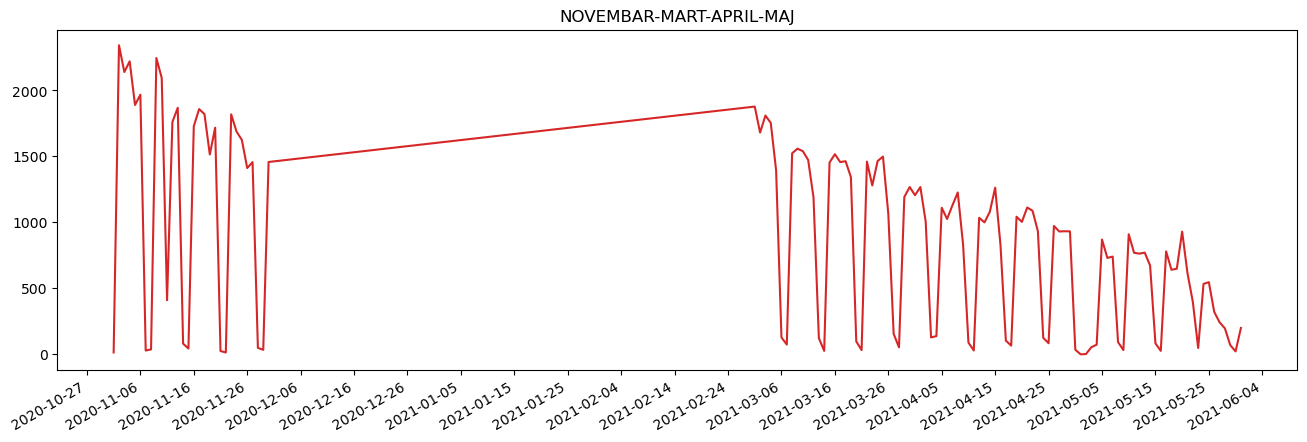

In [248]:
fig = plt.figure(figsize=(16,5), dpi=100)
ax = fig.add_subplot(111)
ax.plot(ts.index, ts.values, 'tab:red')
fig.autofmt_xdate()
plt.title('NOVEMBAR-MART-APRIL-MAJ')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.show()

Posto fali 3 meseca, izbacujem novembar:

In [249]:
ts_mam = pd.concat([meetings_per_day_march, meetings_per_day_april, meetings_per_day_may])
ts_mam.index = pd.to_datetime(ts_mam.index, utc=True)

ts_mam.describe()

count      92.000000
mean      755.413043
std       561.664934
min         0.000000
25%       124.500000
50%       828.500000
75%      1196.250000
max      1878.000000
Name: MEETING_NUMBER, dtype: float64

92 dana

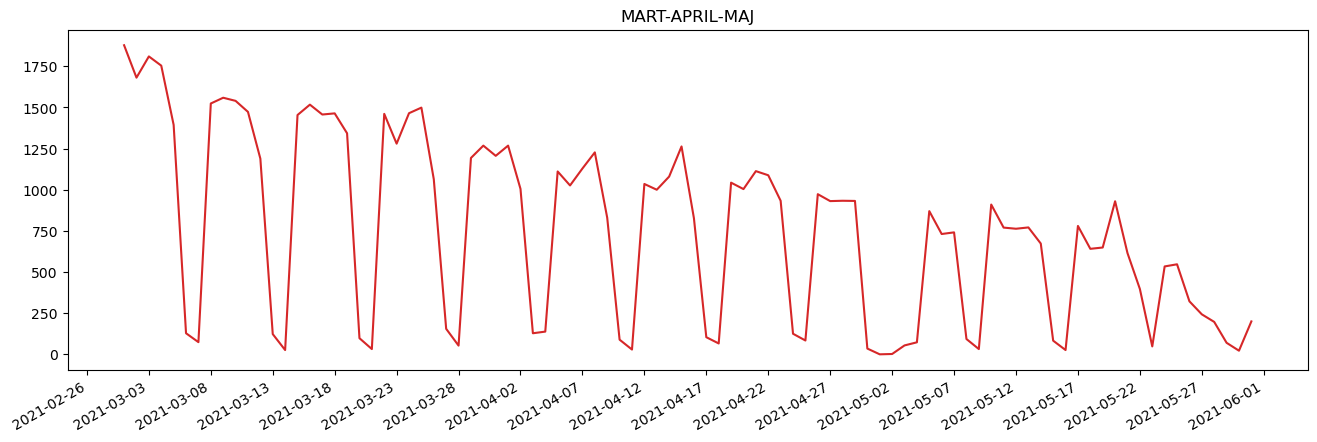

In [251]:
fig = plt.figure(figsize=(16,5), dpi=100)
ax = fig.add_subplot(111)
ax.plot(ts_mam.index, ts_mam.values, 'tab:red')
fig.autofmt_xdate()
plt.title('MART-APRIL-MAJ')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.show()

In [265]:
ts_mam.name = 'Meetings per day'
ts_mam = ts_mam.asfreq('d')

# ako hocu samo radne dane:
# ts_mam = ts_mam.asfreq('b')

In [266]:
ts_mam

JOIN_DATE
2021-03-01 00:00:00+00:00    1878
2021-03-02 00:00:00+00:00    1681
2021-03-03 00:00:00+00:00    1810
2021-03-04 00:00:00+00:00    1754
2021-03-05 00:00:00+00:00    1394
                             ... 
2021-05-27 00:00:00+00:00     243
2021-05-28 00:00:00+00:00     197
2021-05-29 00:00:00+00:00      70
2021-05-30 00:00:00+00:00      22
2021-05-31 00:00:00+00:00     200
Freq: D, Name: Meetings per day, Length: 92, dtype: int64

## QQ plot

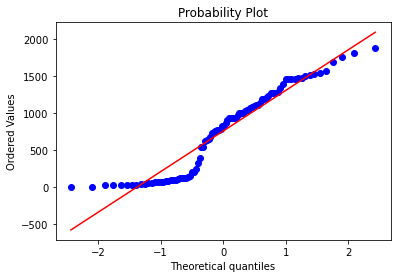

In [252]:
scipy.stats.probplot(ts_mam, plot=pylab)
pylab.show()

- RED LINE = what the data points should follow if they are **normally distributed**

- X-axis = Theoretical quantiles -> How many standard deviations away from the mean these values are

Zakljucak: podaci nemaju normalnu raspodelu

### Stationarity

In [219]:
#check_mean(ts, 'NOVEMBAR-MART-APRIL-MAJ')

Srednja vrednost nije konstantna --> nije stacionarna

In [220]:
check_mean(ts_mam, 'MART-APRIL-MAJ')

MART-APRIL-MAJ: 
Prva trecina: 1098.5333333333333
Druga trecina: 766.2903225806451
Treca trecina: 412.48387096774195
Srednja vrednost na celom skupu: 755.4130434782609



## Dekompozicija

Simply put, time series decomposition is a process of deconstructing a time series into the following components:

- Trend — general movement over time
- Seasonal — behaviors captured in individual seasonal periods
- Residual — everything not captured by trend and seasonal components

There are two techniques for combining time series components:

- Additive
- Multiplicative

We care about these because time series decomposition requires you to specify a model type for the seasonal component. The default is additive, but you can easily change that.

The term additive means individual components (trend, seasonality, and residual) are added together:
An additive trend indicates a linear trend, and an additive seasonality indicates the same frequency (width) and amplitude (height) of seasonal cycles.
The term multiplicative means individual components (trend, seasonality, and residuals) are multiplied together: A multiplicative trend indicates a non-linear trend (curved trend line), and a multiplicative seasonality indicates increasing/decreasing frequency (width) and/or amplitude (height) of seasonal cycles

In [221]:
def decompose(data):
    res = seasonal_decompose(data, model = "additive",period = 7)
    
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(10,8))
    res.trend.plot(ax=ax1,ylabel = "trend")
    res.resid.plot(ax=ax2,ylabel = "seasoanlity")
    res.seasonal.plot(ax=ax3,ylabel = "residual")
    print(res.trend)
    plt.tight_layout()
    plt.show()

In [222]:
#decompose(ts)

JOIN_DATE
2021-03-01 00:00:00+00:00            NaN
2021-03-02 00:00:00+00:00            NaN
2021-03-03 00:00:00+00:00            NaN
2021-03-04 00:00:00+00:00    1245.571429
2021-03-05 00:00:00+00:00    1195.000000
                                ...     
2021-05-27 00:00:00+00:00     276.428571
2021-05-28 00:00:00+00:00     228.714286
2021-05-29 00:00:00+00:00            NaN
2021-05-30 00:00:00+00:00            NaN
2021-05-31 00:00:00+00:00            NaN
Name: trend, Length: 92, dtype: float64


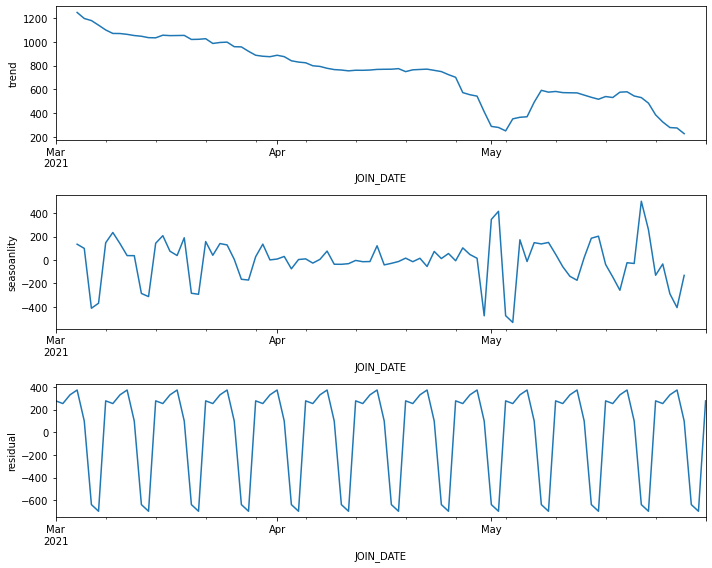

In [223]:
decompose(ts_mam)

## Autokorelacija

So when performing ACF it is advisable to remove any trend present in the data and to make sure the data is stationary.

In [224]:
#acf -> remove trend 
#plt.figure(figsize=(10, 5))
#diff = np.diff(ts.values)
#plt.plot(ts.index[:-1], diff)
#plt.show()

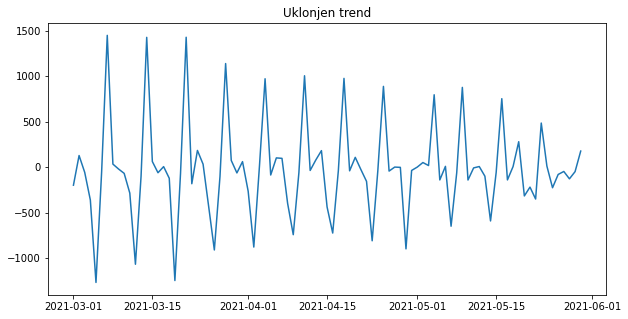

In [225]:
plt.figure(figsize=(10, 5))
diff_mam = np.diff(ts_mam.values)
plt.plot(ts_mam.index[:-1], diff_mam)
plt.title('Uklonjen trend')
plt.show()

In [226]:
#plot_acf(diff)
#plt.show()

We will focus on the points that lie beyond the blue region as they signify strong statistical significance.

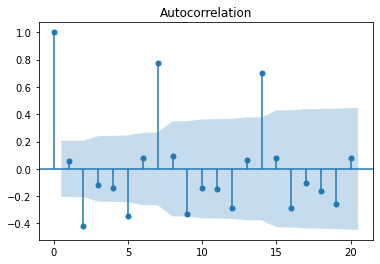

In [253]:
plot_acf(diff_mam)
plt.show()

## Podela na trening i test

Obicno je podela 80% - 20% 

In [279]:
# probacu sa 70-30

size = int(len(ts_mam)*0.7)

In [283]:
df_train = ts_mam.iloc[:size]
df_train.tail()

JOIN_DATE
2021-04-29 00:00:00+00:00    932
2021-04-30 00:00:00+00:00     35
2021-05-01 00:00:00+00:00      0
2021-05-02 00:00:00+00:00      2
2021-05-03 00:00:00+00:00     54
Freq: D, Name: Meetings per day, dtype: int64

In [284]:
df_test = ts_mam.iloc[size:]
df_test.head()

JOIN_DATE
2021-05-04 00:00:00+00:00     73
2021-05-05 00:00:00+00:00    870
2021-05-06 00:00:00+00:00    731
2021-05-07 00:00:00+00:00    741
2021-05-08 00:00:00+00:00     93
Freq: D, Name: Meetings per day, dtype: int64